In [1]:
import numpy as np
import torch

from torchvision.datasets import mnist

import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn.functional as F
import torch.optim as optim
from torch import nn

import matplotlib.pyplot as plt

In [2]:
train_batch_size = 64       
test_batch_size = 128       
learning_rate = 0.01        
num_epoches = 20            
lr = 0.01                   
momentum = 0.5  

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

train_dataset = mnist.MNIST('./data', train=True, transform=transform, download=True)
test_dataset = mnist.MNIST('./data', train=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


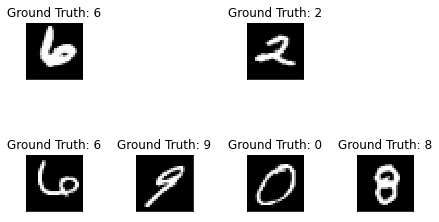

Done.


In [4]:
#Visualization
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
    #plt.pause()
plt.show(block=False)
plt.pause(5)
plt.close()
print("Done.")

In [5]:
class Net(nn.Module):
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))  
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [6]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")

In [7]:
#Put into net.
model = Net(28 * 28, 300, 100, 10)
model.to(device)
print(model)

Net(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [8]:
#Set loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
losses = []
acces = []
eval_losses = []
eval_acces = []

In [9]:
for epoch in range(num_epoches):
    train_loss = 0
    train_acc = 0
    model.train()

In [10]:
if epoch % 5 == 0:
    optimizer.param_groups[0]['lr'] *= 0.1

In [11]:
for img, label in train_loader:
    img = img.to(device)
    label = label.to(device)
    img = img.view(img.size(0), -1)

In [12]:
out = model(img)
loss = criterion(out, label)

In [13]:
optimizer.zero_grad()
loss.backward()
optimizer.step()   

In [14]:
train_loss += loss.item()

In [15]:
_, pred = out.max(1)
num_correct = (pred == label).sum().item()
acc = num_correct / img.shape[0]
train_acc += acc

In [16]:
losses.append(train_loss / len(train_loader))
acces.append(train_acc / len(train_loader)) 

In [17]:
eval_loss = 0
eval_acc = 0

In [18]:
model.eval()
for img, label in test_loader:
    img = img.to(device)
    label = label.to(device)
    img = img.view(img.size(0), -1)
    out = model(img)
    loss = criterion(out, label)

In [19]:
eval_loss += loss.item()

In [20]:
_, pred = out.max(1)
num_correct = (pred == label).sum().item()
acc = num_correct / img.shape[0]
eval_acc += acc

In [22]:
eval_losses.append(eval_loss / len(test_loader))
eval_acces.append(eval_acc/ len(test_loader))
print('epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
      .format(epoch, train_loss / len(train_loader), train_acc / len(train_loader),
                  eval_loss / len(test_loader), eval_acc / len(test_loader)))

epoch: 19, Train Loss: 0.0027, Train Acc: 0.0000, Test Loss: 0.0050, Test Acc: 0.0002


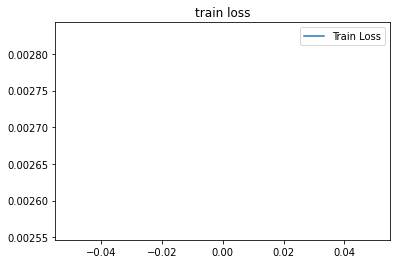

In [23]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)
plt.legend(['Train Loss'], loc='upper right')
plt.show(block=False)
plt.pause(5)
plt.close()